<a href="https://colab.research.google.com/github/guide2157/CNNAutoEncoder-for-image-denoising/blob/master/DenoisingDocumentCNNAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Denoising Documents with CNN Autoencoder

dataset: https://www.kaggle.com/c/denoising-dirty-documents/overview

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import os

Import dataset

In [0]:
from keras.preprocessing import image
idx_dict = dict()
dirty_img = []

index = 0
for img_path in os.listdir("./train"):
  img = image.load_img(os.path.join("./train",img_path), color_mode='grayscale', target_size=(258,540))
  img = np.array(img).astype('float32')
  dirty_img.append(img / 255.)
  idx_dict[img_path]= index
  index += 1

In [0]:
clean_img = [None] * len(dirty_img)

for img_path in os.listdir("./cleaned"):
  img = image.load_img(os.path.join("./cleaned",img_path), color_mode='grayscale', target_size=(258,540))
  img = np.array(img).astype('float32')
  if img_path in idx_dict:
    clean_img[idx_dict[img_path]] = img/255.

Explore the dataset

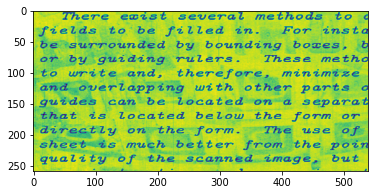

In [31]:
import matplotlib.pyplot as plt

plt.imshow(dirty_img[0])

In [32]:
print("dataset size: ")
len(dirty_img)

dataset size: 


144

Construct the model

In [0]:
from tensorflow.keras.layers import Input, Conv2D, Dense, BatchNormalization, Activation, add, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

In [0]:
inputs = Input(shape=(258,540, 1, ))
head = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
head = BatchNormalization()(head)
head = MaxPooling2D((2, 2), padding='same')(head)
head = Conv2D(64, (3, 3), activation='relu', padding='same')(head)
head = UpSampling2D((2, 2))(head)
outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(head)

model = Model(inputs, outputs)

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(loss='mse', optimizer=optimizer, metrics =["accuracy"])

In [90]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 258, 540, 1)]     0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 258, 540, 64)      640       
_________________________________________________________________
batch_normalization_17 (Batc (None, 258, 540, 64)      256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 129, 270, 64)      0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 129, 270, 64)      36928     
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 258, 540, 64)      0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 258, 540, 1)       577 

Training Model

In [0]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                                       patience=5,
                                       verbose=1, 
                                       mode='auto')

In [0]:
from sklearn.model_selection import train_test_split

X = np.expand_dims(np.array(dirty_img), axis=-1)
y = np.expand_dims(np.array(clean_img), axis=-1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

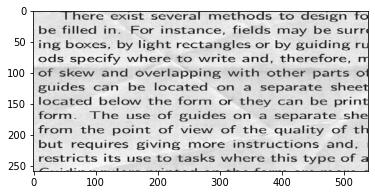

In [112]:
plt.imshow(X_train[0][:,:,0], cmap='gray')

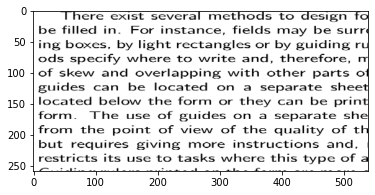

In [113]:
plt.imshow(y_train[0][:,:,0], cmap='gray')

In [0]:
BS = 10
EPOCHS=200

In [0]:
callbacks = [
             early_stopping
]

In [102]:
history = model.fit(
    X_train, y_train,
	  validation_data=(X_val, y_val),
	  batch_size=BS,
    callbacks = callbacks,
	  epochs=EPOCHS
)

Epoch 1/100
13/13 [==============================] - 1s 70ms/step - loss: 0.0734 - accuracy: 0.6683 - val_loss: 0.0685 - val_accuracy: 0.6787
Epoch 2/100
13/13 [==============================] - 1s 63ms/step - loss: 0.0203 - accuracy: 0.7133 - val_loss: 0.0646 - val_accuracy: 0.6787
Epoch 3/100
13/13 [==============================] - 1s 63ms/step - loss: 0.0123 - accuracy: 0.7156 - val_loss: 0.0651 - val_accuracy: 0.6787
Epoch 4/100
13/13 [==============================] - 1s 64ms/step - loss: 0.0089 - accuracy: 0.7165 - val_loss: 0.0632 - val_accuracy: 0.6787
Epoch 5/100
13/13 [==============================] - 1s 63ms/step - loss: 0.0069 - accuracy: 0.7170 - val_loss: 0.0600 - val_accuracy: 0.6787
Epoch 6/100
13/13 [==============================] - 1s 63ms/step - loss: 0.0057 - accuracy: 0.7172 - val_loss: 0.0576 - val_accuracy: 0.6787
Epoch 7/100
13/13 [==============================] - 1s 63ms/step - loss: 0.0049 - accuracy: 0.7173 - val_loss: 0.0551 - val_accuracy: 0.6787
Epoch 

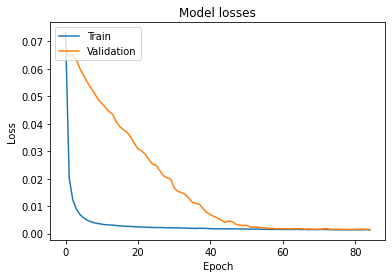

In [103]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Inference

In [0]:
preds = model.predict(X)

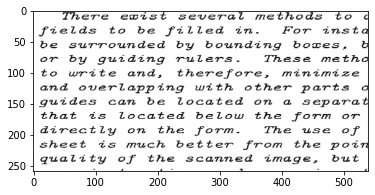

In [110]:
plt.imshow(preds[0,:,:,0], cmap='gray')

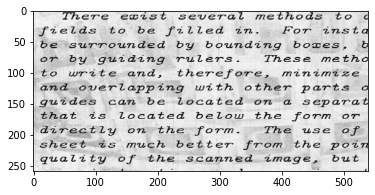

In [111]:
plt.imshow(X[0,:,:,0], cmap='gray')